## Desafío - Dimensionalidad y Agrupación (I)
## Jose Gomez
## Dia de clase: Lunes 15-05-2020 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats 
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore") 
plt.style.use('seaborn')

## Desafío 1: Lectura de archivos

In [3]:
df = pd.read_csv('bfi.csv').drop(columns=['Unnamed: 0'])
df.head()

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
0,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,...,2.0,3.0,3.0,6,3.0,4.0,3.0,1,NaN,16
1,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,...,5.0,5.0,4.0,2,4.0,3.0,3.0,2,NaN,18
2,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,...,2.0,3.0,4.0,2,5.0,5.0,2.0,2,NaN,17
3,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,...,4.0,1.0,3.0,3,4.0,3.0,5.0,2,NaN,17
4,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,2.0,...,4.0,3.0,3.0,3,4.0,3.0,3.0,1,NaN,17


## Desafío 2: Preprocesamiento

In [4]:
import missingno as msngo

In [5]:
df.shape

(2800, 28)

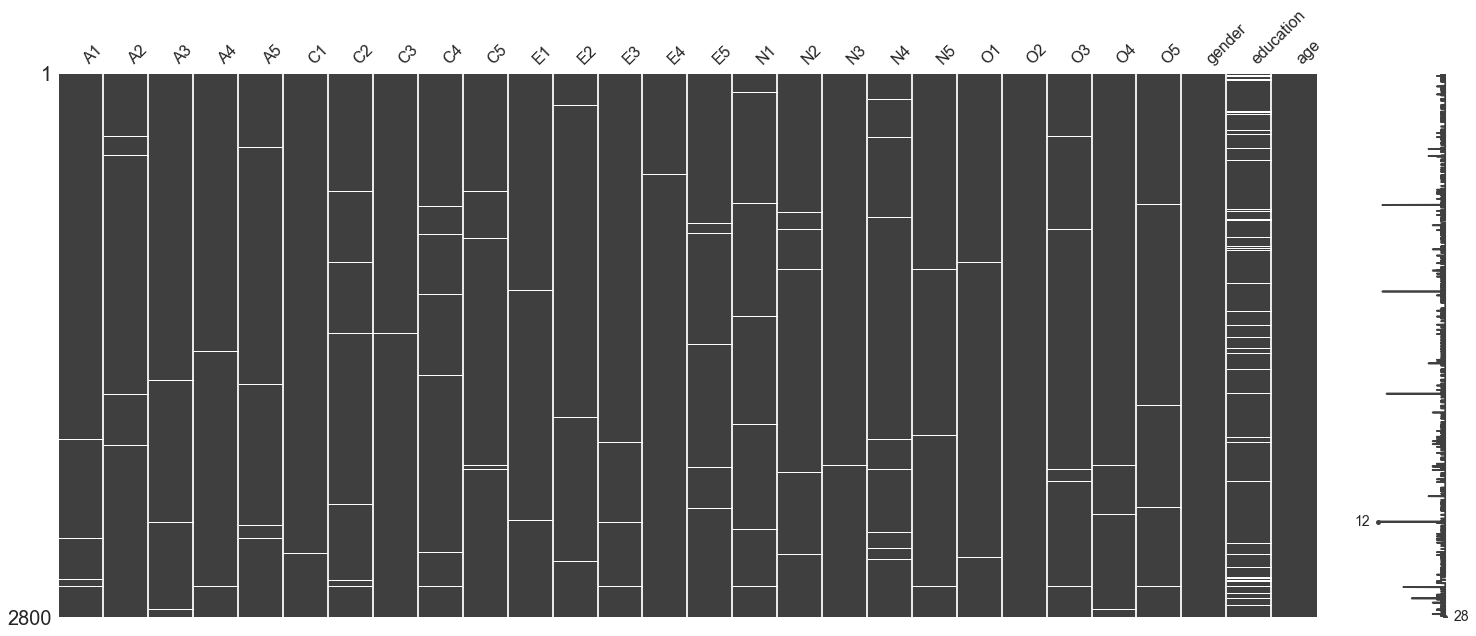

In [60]:
msngo.matrix(df)

In [63]:
def fetch_missing(df): 
    name, porcentaje = [], []
    for colname, serie in df.iteritems():
        if colname not in('age', 'gender', 'O2'):
            name.append(colname)
            porcentaje.append(serie.isna().value_counts('%')[1].round(3))
    return pd.DataFrame({'Columna': name, 'Porcentaje_nulos': porcentaje})

In [67]:
fetch_missing(df).sort_values(by='Porcentaje_nulos', ascending=False).head()

,Columna,Porcentaje_nulos
24,education,0.080
18,N4,0.013
21,O3,0.010
19,N5,0.010
1,A2,0.010


<div class="alert alert-block alert-warning">
Las top 5 variables con mayor cantidad de valores perdidos son: education, N4, O3, N5 y A2
</div><br>

## Desafío 3: Descripción

In [69]:
df2 = df.dropna()

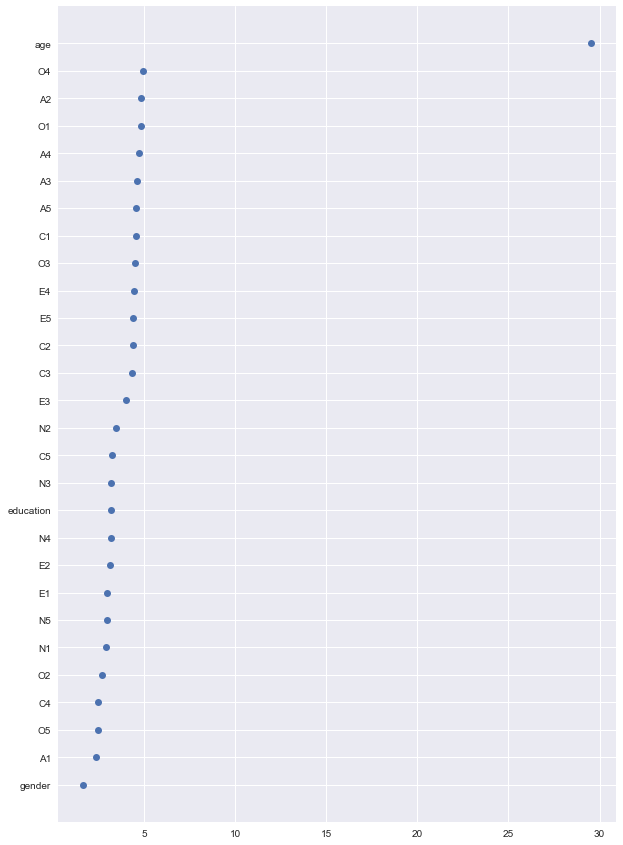

In [73]:
# Generamos dos arrays vacíos para guardar el nombre de la variable y la media
variable = [] 
mean = []

# para cada columna de la base, extraemos su nombre y sus valores
for colname, serie in df2.iteritems(): 
    # guardamos el nombre en variable 
    variable.append(colname)
# calculamos y procesamos la media 
    mean.append(serie.mean())
    
df = pd.DataFrame({'var':variable, 'mean': mean}).sort_values(by=['mean']) 

plt.figure(figsize=(10,15))
plt.plot(df['mean'], df['var'],'o')

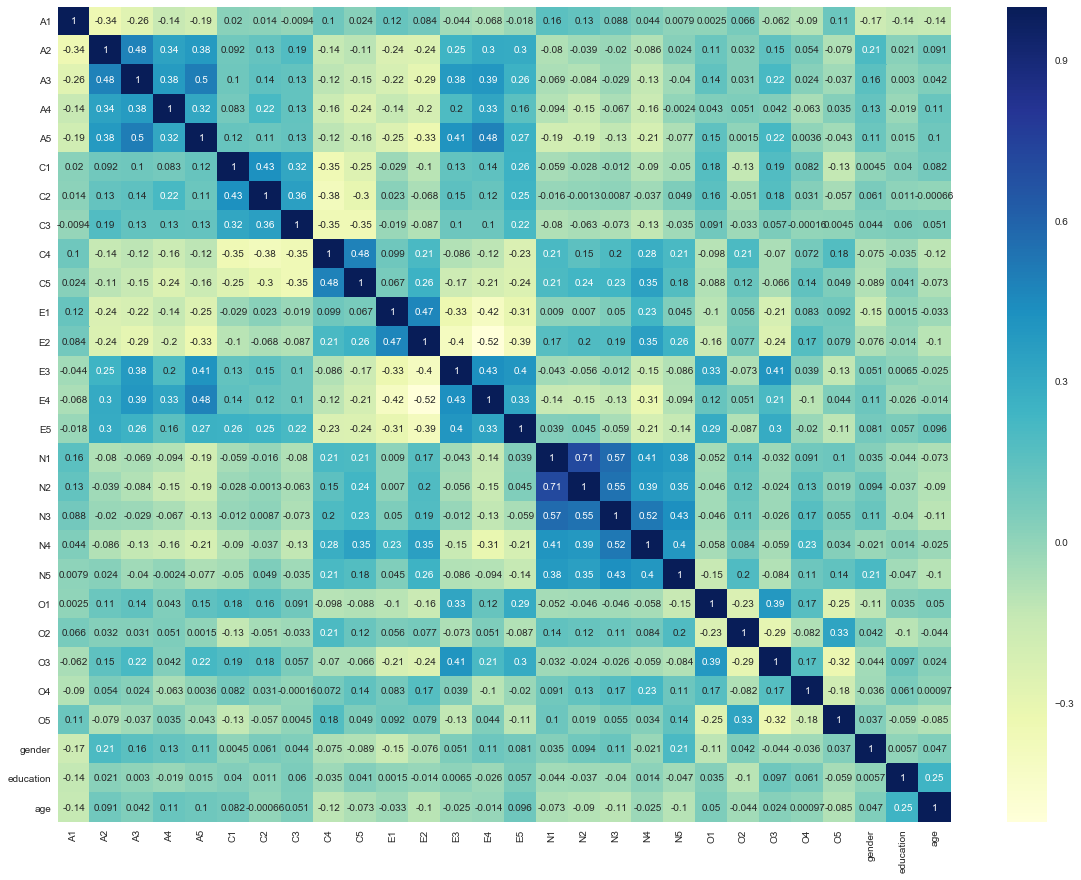

In [87]:
plt.figure(figsize=(20,15))
sns.heatmap(df2.corr(), annot=True, cmap='YlGnBu')

<div class="alert alert-block alert-warning">
De cierta forma, se observa la correlacion entre las frases que se parecen (otros, trabajo, etc).
<br>La frase más aceptada por los encuestados es "O4 Dedico tiempo a la reflexión de cosas"
</div><br>    

## Desafío 4: Extracción de factores

#### Antes de iniciar la extracción de factores, inspeccione la ideonidad de la batería de preguntas para realizar un análisis factorial mediante la prueba de esferacidad de Barlett y Kaiser-Meyer- Olkin. 
Comente los resultados.

In [88]:
import factor_analyzer as fact

In [92]:
#  == Bartlett ==
# chi-squared, p-value
fact.calculate_bartlett_sphericity(df2)

(17359.077419745332, 0.0)

<div class="alert alert-block alert-warning">
En este caso, la prueba de esferacidad de errores sugiere que la matriz de
correlaciones no es igual a la matriz de identidad, por lo que se puede seguir con el análisis
</div><br>    



In [94]:
# == Kaiser-Meyer-Olkin (KMO) ==
#  Valores sobre 0.7 son efectivos, bajo esto, deben ser eliminados
# Return: [Vector con cada KMO], puntaje global
fact.calculate_kmo(df2)

(array([0.75129086, 0.84380058, 0.87259439, 0.86196987, 0.89609538,
        0.83302616, 0.78347906, 0.84259756, 0.82855151, 0.85692691,
        0.84543297, 0.88171534, 0.89014498, 0.87432169, 0.89167722,
        0.77258165, 0.77820795, 0.8586007 , 0.87843955, 0.84636179,
        0.85238344, 0.78043226, 0.83381538, 0.78621003, 0.76220566,
        0.71209407, 0.58446076, 0.60850663]), 0.8385815853066401)

<div class="alert alert-block alert-warning">
En este caso, la prueba de KMO sugiere que se puede seguir con el análisis factorial
</div><br>  

#### Instancie un objeto con FactorAnalyzer() donde se estimen 10 dimensiones latentes y no se aplique rotación.


In [98]:
# Generamos una nueva instancia en el objeto factorize
factorize = fact.FactorAnalyzer(n_factors=10,rotation=None)

# Implementamos el análisis
factorize.fit(df2)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=10, rotation=None, rotation_kwargs={},
               use_smc=True)

#### Genere un scree plot entre los eigenvalues del modelo y la cantidad de dimensiones estimables.

In [105]:
factor_screeplot = factorize.get_eigenvalues()[0]

In [109]:
eigen = pd.DataFrame({'factor': [i for i in range(0,len(factor_screeplot))], 'valor': factor_screeplot})

Text(0.5, 1.0, 'Scree plot')

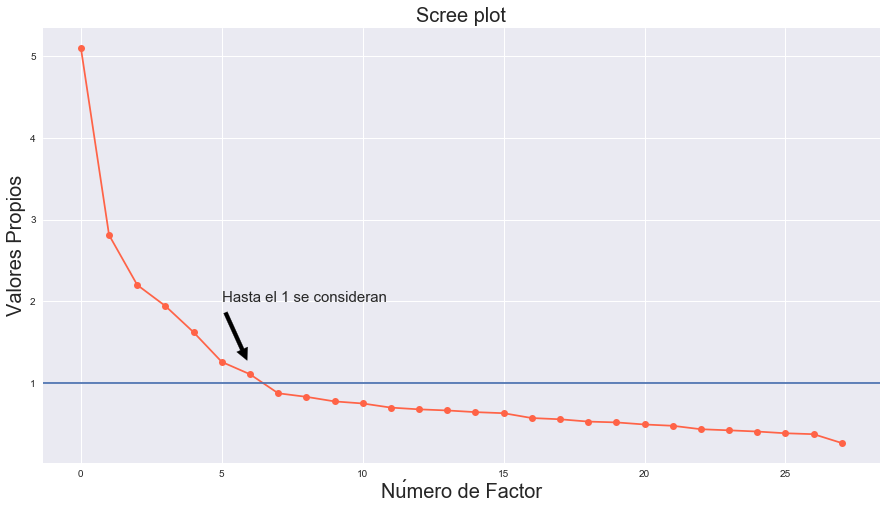

In [132]:
# graficamos los eigenvalues contra la cantidad de dimensiones estimables 
plt.figure(figsize=(15,8))
plt.plot(eigen['factor'], eigen['valor'], 'o-', color='tomato') 
plt.xlabel('Número de Factor',fontsize=20)
plt.ylabel('Valores Propios',fontsize=20)
# visualizamos el criterio de corte
plt.axhline(1)
plt.annotate('Hasta el 1 se consideran', xy=(6,1.2), xytext=(5, 2),
            arrowprops=dict(facecolor='black', shrink=0.1),fontsize=15)
plt.title("Scree plot", fontsize = 20)

<div class="alert alert-block alert-warning">
La evidencia apunta que nuestro modelo está correctamente especificado, y tenemos <b>7</b> grandes dimensiones no observables.
</div><br>  

#### Refactorice el objeto con FactorAnalyzer() para incluir la cantidad de dimensiones válidas que informó el scree plot.

In [133]:
# Generamos una nueva instancia en el objeto factorize
factorize_2 = fact.FactorAnalyzer(n_factors=7,rotation=None)

# Implementamos el análisis
factorize_2.fit(df2)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=7, rotation=None, rotation_kwargs={},
               use_smc=True)

#### Extraiga las cargas   del modelo e identifique qué items están asociados a cada factor. Comente sobre qué significa cada factor construído.

In [143]:
loadings = pd.DataFrame(factorize_2.loadings_)

In [144]:
loadings['variable'] = df2.columns

In [148]:
loadings.set_index('variable', inplace=True)

In [150]:
loadings.columns = ['Factor'+str(i+1) for i in loadings.columns]

In [151]:
loadings.applymap(lambda x: np.where(x < .4, ' ', round(x, 2)))

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
variable,,,,,,,
A1,,,,,,,
A2,0.46,,,,,,
A3,0.52,,,,,,
A4,0.4,,,,,,
A5,0.57,,,,,,
C1,,,0.42,,,,
C2,,,0.41,,,,
C3,,,,,,,
C4,,,,,,,


<div class="alert alert-block alert-warning">
El Factor 1 apunta a la Amabilidad y la Extroversion.
<br>El Factor 2 apunta al Neuroticismo.
<br>El Factor 3 apunta a Escrupolisidad.
</div><br>  


## Desafío 5: Modelación de factores
#### Extraiga los puntajes del modelo factorial a su base de datos.

In [155]:
extract_factor_scores = factorize_2.transform(df2) 

 # get_score no funciona  :@

In [168]:
extract_factor_scores2 = pd.DataFrame(extract_factor_scores)

In [171]:
extract_factor_scores2.columns = ['Factor'+str(i+1) for i in extract_factor_scores2.columns]
extract_factor_scores2.head()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
0,1.064696,0.703908,0.670916,0.535990,-1.178754,0.122635,-0.265085
1,-2.235533,-0.833070,0.479942,-0.138897,-0.859823,-0.231235,-0.689029
2,-0.072911,-0.219214,-0.430246,-0.051185,-0.831516,0.537511,-0.478891
3,-0.364622,-0.868990,0.790251,0.473071,-1.795812,0.443885,-0.565760
4,0.375177,-0.788924,-0.993902,-1.655195,1.376783,-1.144232,1.482818


In [172]:
extract_factor_scores2.shape

(2236, 7)

In [177]:
df2.reset_index(drop=True, inplace=True)

In [178]:
df2.head()

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
0,6.0,6.0,5.0,6.0,5.0,6.0,6.0,6.0,1.0,3.0,...,2.0,3.0,4.0,3,5.0,6.0,1.0,2,3.0,21
1,4.0,3.0,1.0,5.0,1.0,3.0,2.0,4.0,2.0,4.0,...,6.0,4.0,3.0,2,4.0,5.0,3.0,1,2.0,19
2,4.0,4.0,5.0,6.0,5.0,4.0,3.0,5.0,3.0,2.0,...,2.0,3.0,5.0,3,5.0,6.0,3.0,1,1.0,21
3,4.0,5.0,2.0,2.0,1.0,5.0,5.0,5.0,2.0,2.0,...,2.0,3.0,5.0,2,5.0,5.0,5.0,1,1.0,17
4,1.0,5.0,6.0,5.0,6.0,4.0,3.0,2.0,4.0,5.0,...,2.0,2.0,6.0,1,5.0,5.0,2.0,1,5.0,68


In [179]:
concatenado = pd.concat([df2, extract_factor_scores2], axis=1)

In [180]:
concatenado.head()

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,gender,education,age,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
0,6.0,6.0,5.0,6.0,5.0,6.0,6.0,6.0,1.0,3.0,...,2,3.0,21,1.064696,0.703908,0.670916,0.535990,-1.178754,0.122635,-0.265085
1,4.0,3.0,1.0,5.0,1.0,3.0,2.0,4.0,2.0,4.0,...,1,2.0,19,-2.235533,-0.833070,0.479942,-0.138897,-0.859823,-0.231235,-0.689029
2,4.0,4.0,5.0,6.0,5.0,4.0,3.0,5.0,3.0,2.0,...,1,1.0,21,-0.072911,-0.219214,-0.430246,-0.051185,-0.831516,0.537511,-0.478891
3,4.0,5.0,2.0,2.0,1.0,5.0,5.0,5.0,2.0,2.0,...,1,1.0,17,-0.364622,-0.868990,0.790251,0.473071,-1.795812,0.443885,-0.565760
4,1.0,5.0,6.0,5.0,6.0,4.0,3.0,2.0,4.0,5.0,...,1,5.0,68,0.375177,-0.788924,-0.993902,-1.655195,1.376783,-1.144232,1.482818


In [181]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Desafío 5: Modelación de factores
## Comentario

<div class="alert alert-block alert-warning">
Las regresiones están hacia abajo, pero vale destacar que tanto <b>education y gender</b> (en ese orden) son los principales determinantes de cada factor.
</div><br>  

In [194]:
model_1 = smf.ols('Factor1 ~ gender + education + age', data = concatenado).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Factor1   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     30.90
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           1.44e-19
Time:                        20:36:54   Log-Likelihood:                -3011.3
No. Observations:                2236   AIC:                             6031.
Df Residuals:                    2232   BIC:                             6053.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8373      0.100     -8.402      0.000      -1.033      -0.642
gender         0.2117      0.042      5.045      0.000       0.129       0.294
education      0.0223      0.018      1.220      0.222      -0.014       0.058
age            0.0140      0.002      7.316      0.000       0.010       0.018
==============================================================================
Omnibus:                       29.429   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.291
Skew:                          -0.279   Prob(JB):                     2.64e-07
Kurtosis:                       2.881   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [195]:
model_2 = smf.ols('Factor2 ~ gender + education + age', data = concatenado).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Factor2   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     46.43
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           4.18e-29
Time:                        20:37:01   Log-Likelihood:                -2909.0
No. Observations:                2236   AIC:                             5826.
Df Residuals:                    2232   BIC:                             5849.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5704      0.095     -5.992      0.000      -0.757      -0.384
gender         0.4563      0.040     11.382      0.000       0.378       0.535
education     -0.0008      0.017     -0.044      0.965      -0.035       0.034
age           -0.0064      0.002     -3.527      0.000      -0.010      -0.003
==============================================================================
Omnibus:                        4.117   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                4.103
Skew:                           0.080   Prob(JB):                        0.129
Kurtosis:                       3.135   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [196]:
model_3 = smf.ols('Factor3 ~ gender + education + age', data = concatenado).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Factor3   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     39.50
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           7.22e-25
Time:                        20:37:06   Log-Likelihood:                -2780.4
No. Observations:                2236   AIC:                             5569.
Df Residuals:                    2232   BIC:                             5592.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1700      0.090      1.891      0.059      -0.006       0.346
gender        -0.3380      0.038     -8.930      0.000      -0.412      -0.264
education      0.0849      0.017      5.143      0.000       0.053       0.117
age            0.0042      0.002      2.441      0.015       0.001       0.008
==============================================================================
Omnibus:                       31.474   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.199
Skew:                           0.196   Prob(JB):                     1.87e-09
Kurtosis:                       3.527   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
model_4 = smf.ols('Factor4 ~ gender + education + age', data = concatenado).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Factor4   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     62.31
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           1.10e-38
Time:                        20:34:15   Log-Likelihood:                -2683.9
No. Observations:                2236   AIC:                             5376.
Df Residuals:                    2232   BIC:                             5399.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4916      0.086     -5.711      0.000      -0.660      -0.323
gender         0.4489      0.036     12.383      0.000       0.378       0.520
education     -0.0903      0.016     -5.714      0.000      -0.121      -0.059
age            0.0010      0.002      0.606      0.545      -0.002       0.004
==============================================================================
Omnibus:                       13.258   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.064
Skew:                          -0.076   Prob(JB):                     0.000197
Kurtosis:                       3.400   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [197]:
model_5 = smf.ols('Factor5 ~ gender + education + age', data = concatenado).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Factor5   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     143.7
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           3.92e-85
Time:                        20:37:25   Log-Likelihood:                -2491.3
No. Observations:                2236   AIC:                             4991.
Df Residuals:                    2232   BIC:                             5013.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4837      0.079    -18.787      0.000      -1.639      -1.329
gender         0.2678      0.033      8.051      0.000       0.203       0.333
education      0.1372      0.014      9.465      0.000       0.109       0.166
age            0.0203      0.002     13.397      0.000       0.017       0.023
==============================================================================
Omnibus:                       22.155   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.036
Skew:                          -0.123   Prob(JB):                     3.00e-07
Kurtosis:                       3.512   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [198]:
model_6 = smf.ols('Factor6 ~ gender + education + age', data = concatenado).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Factor6   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     319.1
Date:                Sat, 20 Jun 2020   Prob (F-statistic):          2.12e-172
Time:                        20:37:40   Log-Likelihood:                -2101.8
No. Observations:                2236   AIC:                             4212.
Df Residuals:                    2232   BIC:                             4235.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8210      0.066     27.445      0.000       1.691       1.951
gender        -0.3649      0.028    -13.060      0.000      -0.420      -0.310
education     -0.1113      0.012     -9.140      0.000      -0.135      -0.087
age           -0.0290      0.001    -22.813      0.000      -0.031      -0.027
==============================================================================
Omnibus:                       75.875   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.939
Skew:                           0.098   Prob(JB):                     2.83e-43
Kurtosis:                       4.437   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [199]:
model_7 = smf.ols('Factor7 ~ gender + education + age', data = concatenado).fit()
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Factor7   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     814.3
Date:                Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:37:51   Log-Likelihood:                -1358.4
No. Observations:                2236   AIC:                             2725.
Df Residuals:                    2232   BIC:                             2748.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7818      0.048    -16.431      0.000      -0.875      -0.689
gender        -0.4060      0.020    -20.259      0.000      -0.445      -0.367
education      0.1405      0.009     16.082      0.000       0.123       0.158
age            0.0343      0.001     37.616      0.000       0.033       0.036
==============================================================================
Omnibus:                       98.664   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.002
Skew:                           0.367   Prob(JB):                     4.02e-36
Kurtosis:                       4.100   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""